# Sentinel-2 Field Parcel Extraction

Author: [Lukas Valentin Graf](https://github.com/lukasValentin/lukasValentin) (2022-2023)

## Learning Objectives

In this notebook you will learn how to

* rasterize vector features
* extract agricultural field parcels with a specific crop type from a Sentinel-2 scene
* export the pixels of a specific crop type to a GeoPandas GeoDataFrame

## Tutorial Content

This tutorial is introductorial level. 

Basic knowledge about [GeoPandas](https://geopandas.org/en/stable/) might be helpful.

To run this notebook no additional requirements in terms of software-setup are necessary.

The data required to run this notebook can be found [here](./../data).

In [7]:
# load required modules
import cv2
import numpy as np
import geopandas as gpd

from pathlib import Path
from eodal.core.sensors import Sentinel2

# make plots larger by default
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [8]:
# we need to tell EOdal that we work using a local data source
from eodal.config import get_settings
settings = get_settings()
settings.USE_STAC = False

We use a Sentinel-2 scene acquired over southern Bavaria in 2019 and some field parcels that were manually delimited and labelled with three different crop types.

In [9]:
# download test data (if not done yet)
import requests
from eodal.downloader.sentinel2.utils import unzip_datasets

# URL to the public dataset
url = 'https://data.mendeley.com/public-files/datasets/ckcxh6jskz/files/e97b9543-b8d8-436e-b967-7e64fe7be62c/file_downloaded'

testdata_dir = Path('../../data')
testdata_fname = testdata_dir.joinpath('S2A_MSIL2A_20190524T101031_N0212_R022_T32UPU_20190524T130304.zip')
testdata_fname_unzipped = Path(testdata_fname.as_posix().replace('.zip', '.SAFE'))

# check first if the dataset has been already downloaded; only start the download if the dataset is not yet available locally
if not testdata_fname_unzipped.exists():

    # download dataset
    r = requests.get(url, stream=True)
    r.raise_for_status()
    with open(testdata_fname, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=5096):
            fd.write(chunk)

    # unzip dataset
    unzip_datasets(download_dir=testdata_dir)

Open the Sentinel-2 dataset (all 10 and 20m bands plus the scene classification layer) for the bounding box in which all of the field parcels are located.

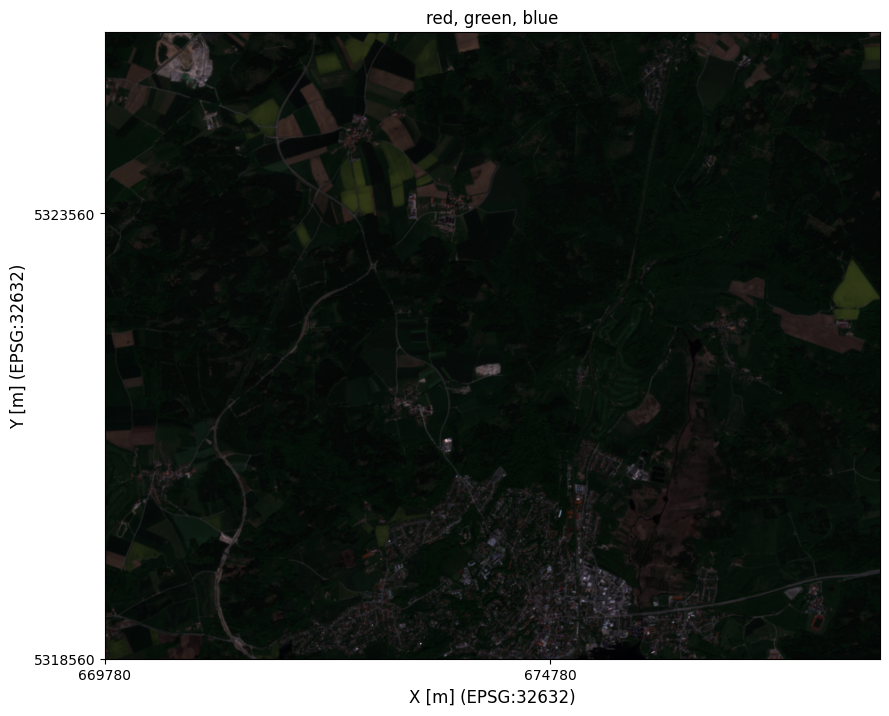

In [10]:
# define file-path to ESRI shapefile (all formats understood by fiona work)
import os

base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
field_parcels = base_dir.joinpath('data/sample_polygons/BY_Polygons_Canola_2019_EPSG32632.shp')

# read data from .SAFE dataset for the selected AOI and spectral bands
handler = Sentinel2().from_safe(
    in_dir=testdata_fname_unzipped,
    vector_features=field_parcels,
    full_bounding_box_only=True
)

fig_rgb = handler.plot_multiple_bands(['red','green','blue'])

The parcel polygons are vector features (ESRI shapefile). We can open them using GeoPandas:

In [11]:
parcels_gdf = gpd.read_file(field_parcels)
parcels_gdf.head()

,id,crop_code,crop_type,geometry
0,1,1,Canola,"POLYGON ((11.28091 48.00947, 11.28463 48.00837..."
1,2,1,Canola,"POLYGON ((11.27627 47.99920, 11.27718 47.99970..."
2,3,1,Canola,"POLYGON ((11.31743 48.01035, 11.31907 48.01035..."
3,4,1,Canola,"POLYGON ((11.39011 48.03560, 11.39414 48.03179..."
4,5,1,Canola,"POLYGON ((11.31546 48.04705, 11.31665 48.04720..."


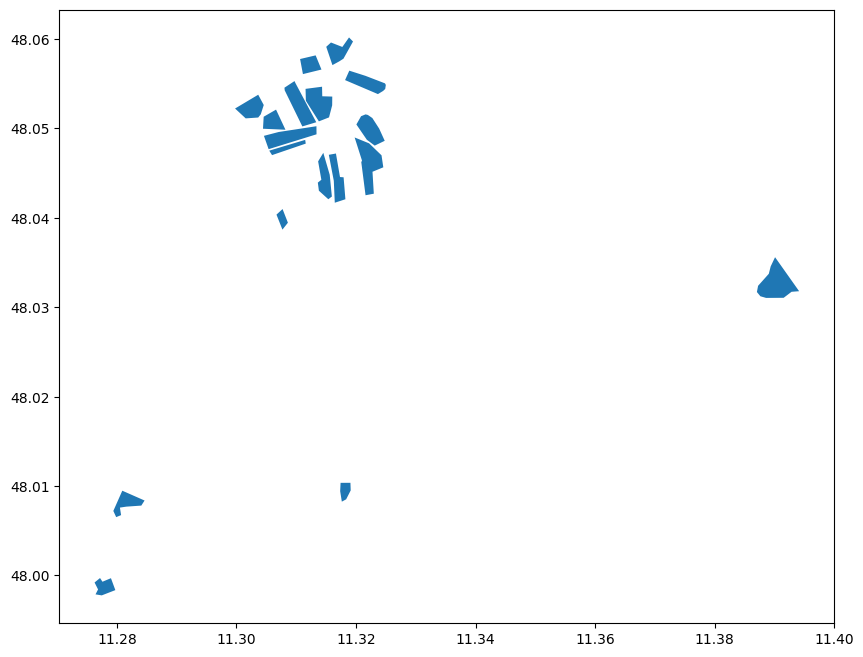

In [12]:
parcels_plot = parcels_gdf.plot()

We can rasterize the `crop_code` attribute and add it as a new band to the `handler` object. To do so, we call use a constructor for the `Band` class. 

In [13]:
from eodal.core.band import Band

handler.add_band(
    band_constructor=Band.from_vector,
    vector_features=parcels_gdf,         
    geo_info=handler['blue'].geo_info,  # we use the geo-localisation and spatiaol coordinate system of one of the 10m bands
    snap_bounds=handler['blue'].bounds, # and define the extent of the rasterized vector features to match the extent of the blue band
    band_name_src='crop_code',          # we can use any numeric attribute of the vector features; each attribute becomes a new raster band
    band_name_dst='crop_code'
)

The visualization of the `crop_code` band shows how the rasterized features now look like.

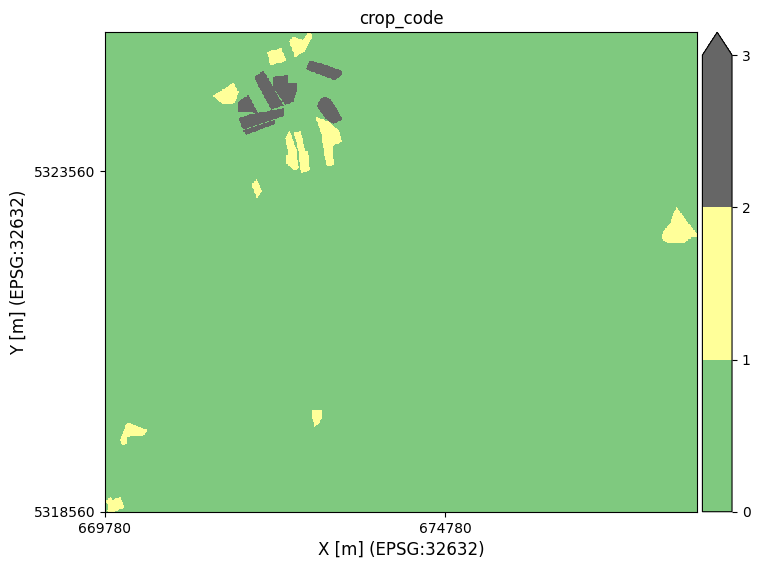

In [14]:
fig_cc = handler.plot_band('crop_code', colormap='Accent', discrete_values=True)

Now we can mask all pixels not labelled as rapeseed (crop code == 1). Since all to mask must have the same spatial resolution (10m) we have to resample the 20m bands to 10m first (or vice versa).

In [15]:
# resample to 10m first
handler.resample(
    target_resolution=10,   # meter
    interpolation_method=cv2.INTER_NEAREST_EXACT,
    inplace=True
)

bands_to_mask = handler.band_names

handler.mask(
    mask='crop_code',
    mask_values=[1],  # 1 is the code for canola
    bands_to_mask=bands_to_mask,
    keep_mask_values=True,  # we want to keep all canola pixels,
    inplace=True
)

Plotting the rapeseed parcel in true color RGB format shows how that the rapeseed plants were flowering (very yellow appearance):

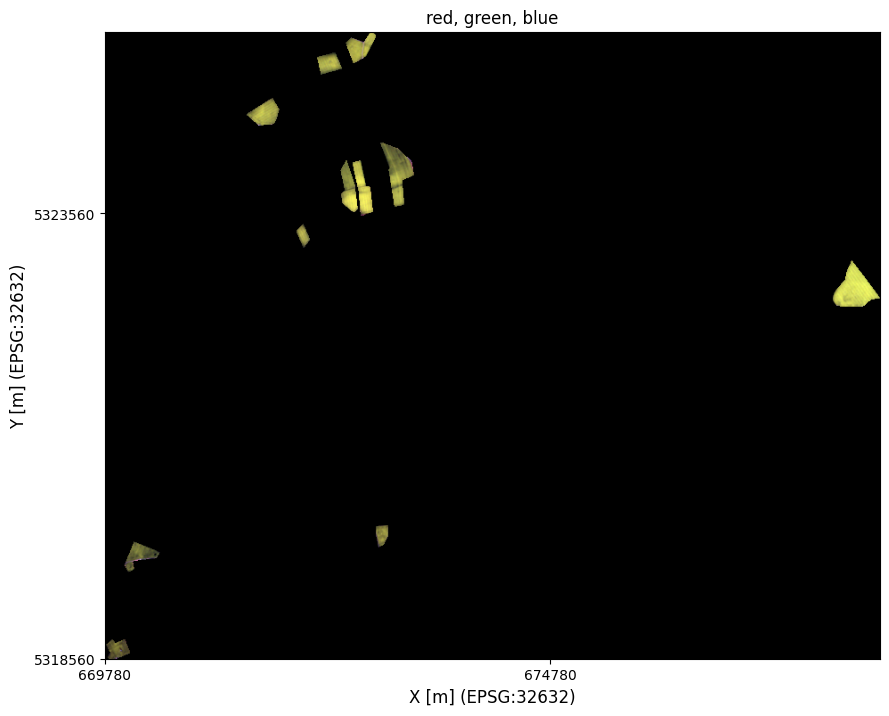

In [16]:
fig_rgb_rapeseed = handler.plot_multiple_bands(['red','green','blue'])

Finally, we can convert the raster data into a GeoPandas GeoDataFrame to apply further data analysis:

In [17]:
gdf_rapeseed_pixels = handler.to_dataframe()
gdf_rapeseed_pixels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7508 entries, 0 to 7507
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   geometry   7508 non-null   geometry
 1   B02        7508 non-null   float64 
 2   B03        7508 non-null   float64 
 3   B04        7508 non-null   float64 
 4   B05        7508 non-null   float64 
 5   B06        7508 non-null   float64 
 6   B07        7508 non-null   float64 
 7   B08        7508 non-null   float64 
 8   B8A        7508 non-null   float64 
 9   B11        7508 non-null   float64 
 10  B12        7508 non-null   float64 
 11  SCL        7508 non-null   uint8   
 12  crop_code  7508 non-null   float32 
dtypes: float32(1), float64(10), geometry(1), uint8(1)
memory usage: 682.0 KB


In [18]:
gdf_rapeseed_pixels.head()

,geometry,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,SCL,crop_code
0,POINT (669790.000 5318730.000),0.0371,0.0898,0.0588,0.1437,0.3430,0.3793,0.5176,0.4029,0.2080,0.1386,4,1.0
1,POINT (669790.000 5318720.000),0.0375,0.0916,0.0580,0.1440,0.3438,0.3999,0.5128,0.4124,0.1979,0.1211,4,1.0
2,POINT (669800.000 5318730.000),0.0404,0.1090,0.0880,0.1499,0.4327,0.5409,0.5612,0.5400,0.1577,0.0791,4,1.0
3,POINT (669800.000 5318720.000),0.0410,0.1012,0.0776,0.1431,0.4396,0.5325,0.5456,0.5421,0.1484,0.0732,4,1.0
4,POINT (669800.000 5318710.000),0.0395,0.0936,0.0662,0.1431,0.4396,0.5325,0.5372,0.5421,0.1484,0.0732,4,1.0


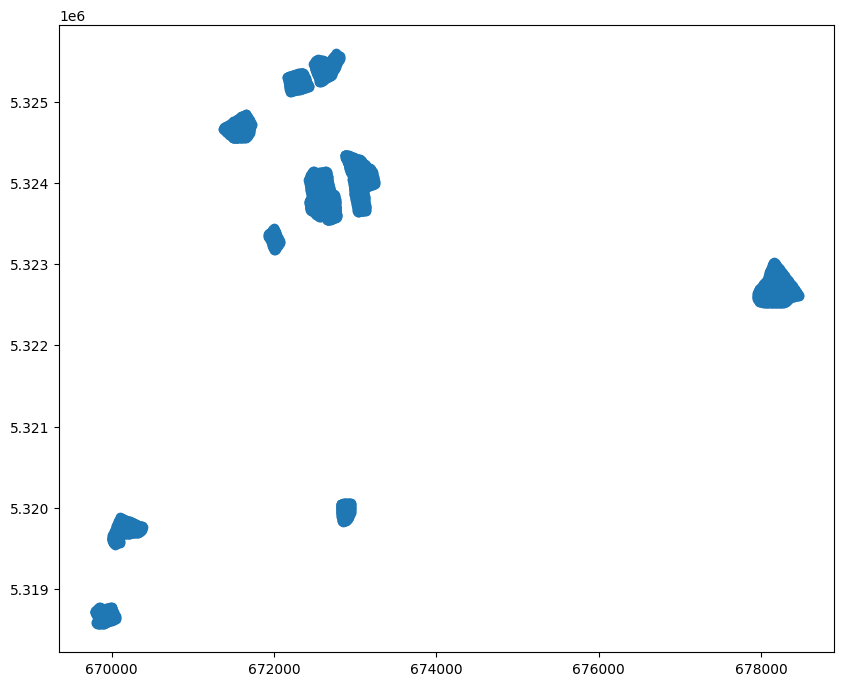

In [13]:
canola_rapeseed_plot = gdf_rapeseed_pixels.plot()